<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GANy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description

Generative Adversial Network for Artificial ECG Generation


# Install python packages

In [1]:
!pip3 install scipy keras

# Imports

In [2]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.layers import LeakyReLU

# numpy
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import pyplot
from timeit import default_timer as timer
# import rasterio






Using TensorFlow backend.


# Google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Paths

In [0]:
#MATDATA - signal database (.mat)
MATDATA_PATH = WORKDIR_PATH / "Matdata"
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = MATDATA_PATH / "annotFull.mat"
SIGNAL_PATH=MATDATA_PATH / "annotFull.mat"

# Python tricks

In [0]:
#ARRAY IN ARRAY PROBLEM
#removing unnecessary braces like []
#example:

labels_names = matlab_data['annotLabel']
print('Names of labels ->' + str(labels_names))
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

#Data manipulation (signals and lables)

In [19]:
matlab_data = scipy.io.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# annotation_list = labels_names
# replace("'",'').

signal_labels[0][0]


IndexError: ignored

# Creating the database

In [0]:
#AF=SINUS=SVR=VR=OTHER=AVB=BBB=ABSV=PVC=NOISY= []
def signal_type(i):
  switcher={
      0:AF,
      1:SINUS,
      2:SVR,
      3:VR,
      4:OTHER,
      5:AVB,
      6:BBB,
      7:ABSV,
      8:PVC,
      9:NOISY
    }
  return switcher.get(i,"Invalid number of label")

counter=0
for counter in range(10):
  for x in range(len(signal_labels)):
    if str(signal_labels[x][counter]) == '1' and sum(eval(signal_labels[x])) < 2 :
      signal_type(counter)=signal_type(counter).append(signal_names[x])


# len cisty sinusovy rytmus, nic ine
# do premennej sinus rhythm files si ukladam nazvy mat suborov (EB000.....mat) co splnaju tieto podmienky

for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(item[0]).replace('[', '').replace("'", '').replace(']', ''))
      

print(counter)
print(AF)
print(len(SINUS))
print(PVC)
print(len(NOISY))

TypeError: ignored

# Signal generation, x2, generate samples, generate real samples, generate fake samples


vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)


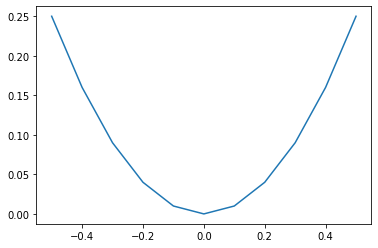

Vystup z nahodnych od -0,5 do 0,5 (100 vzoriek):


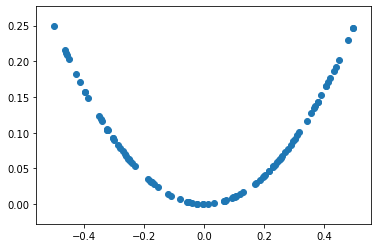

Vystup z nahodnych od -1 do 1 (100 vzoriek):


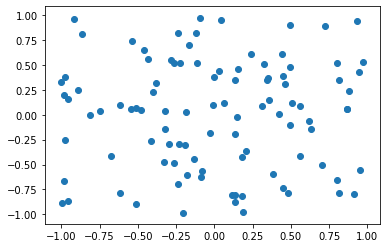

In [0]:
# y = f(x)

# demonstrate simple x^2 function

def calculate(x):
	return x * x

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
print('vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)')
pyplot.plot(inputs, outputs)
pyplot.show()

# example of generating random samples from X^2
# # generate randoms sample from x^2 - FUNKCIA

def generate_samples(n=100):
	X1 = rand(n) - 0.5
	# print('Nahodne hodnoty v rozmedzi -0.5 az 0.5')
	# print(X1)
	X2 = X1 * X1
	# stack arrays - spojim dva stlpce X1 a X2
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))  #vystup je v returne, dalej ukladam do x2_data 

# generate n REAL samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1)) # tymto hovorim ze vsetky vygenerovane data su real, same jednotky
	return X, y

# generate n FAKE samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	#print('Nahodne hodnoty v rozmedzi -1 az 1')
	#print(X1)
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1)) # tymto hovorim ze vsetky vygenerovane data su fake, same nuly
	return X, y 
 	
# generate samples
x2_data = generate_samples() 
# plot samples
print('Vystup z nahodnych od -0,5 do 0,5 (100 vzoriek):')
pyplot.scatter(x2_data[:, 0], x2_data[:, 1])
pyplot.show()

# generate fake samples
print('Vystup z nahodnych od -1 do 1 (100 vzoriek):')
[X,y] = generate_fake_samples(100) 
# plot samples
pyplot.scatter(X[:,0], X[:,1])
pyplot.show()

# Define a Discriminator model = loss+optimization+metrics






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


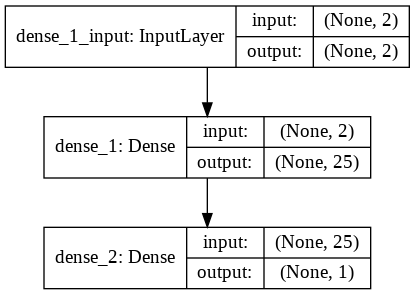

In [0]:

# Inputs: Sample with two real values. (vstup1 : vstupny stlpec,vstup2: vystupny stlpec)
# Outputs: Binary classification, likelihood the sample is real (or fake). 0/1

# One hidden layer with 25 nodes 
# We will use the ReLU activation function and an appropriate weight initialization method called He weight initialization.

# The output layer will have one node for the binary classification using the sigmoid activation function.

# Adam version of stochastic gradient descent 

# define the standalone discriminator model - FUNKCIA
# https://keras.io/getting-started/sequential-model-guide/


def define_discriminator(n_inputs=2):
	discriminator_model = Sequential() #The Sequential model is a linear stack of layers.
	discriminator_model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))  # dense=2D layer, musi poznat imput - zadavam cez inputshape, imput dim - atd vid link
	discriminator_model.add(Dense(1, activation='sigmoid'))
 

# definujeme loss funkciu,   optimalizer-sposob ucenia?,     metrics - hodnoti vykon,spravnost modelu = metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model. You may use any of the loss functions as a metric function.
# https://keras.io/losses/    https://keras.io/optimizers/    https://keras.io/metrics/

	# compile model
	discriminator_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return discriminator_model


# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)



# Training the Discriminator model

In [0]:
# This can be achieved by manually enumerating the training epochs and for each epoch generating a half batch of real examples and a half batch of fake examples, and updating the model on each, e.g. one whole batch of examples.
# The train_discriminator() function below implements this, training the model for 1,000 batches and using 128 samples per batch (64 fake and 64 real).

# The model can then be evaluated on the generated examples and we can report the classification accuracy on the real and fake samples.


def train_discriminator(discriminator_model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
  # run epochs manually 1000x
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		discriminator_model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		discriminator_model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = discriminator_model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)
  
# fit the model
train_discriminator(discriminator_model)

# Your specific results may vary but the model rapidly learns to correctly identify the real examples with perfect accuracy and is very good at identifying the fake examples with 80% to 90% accuracy.
# Training the discriminator model is straightforward. The goal is to train a generator model, not a discriminator model, and that is where the complexity of GANs truly lies. 









0 0.484375 0.375
1 0.625 0.390625
2 0.5 0.421875
3 0.65625 0.375
4 0.421875 0.40625
5 0.46875 0.46875
6 0.578125 0.390625
7 0.5 0.5625
8 0.515625 0.453125
9 0.4375 0.5
10 0.5 0.390625
11 0.5 0.40625
12 0.515625 0.4375
13 0.5625 0.375
14 0.515625 0.34375
15 0.46875 0.453125
16 0.578125 0.359375
17 0.609375 0.421875
18 0.453125 0.328125
19 0.546875 0.375
20 0.609375 0.453125
21 0.5 0.46875
22 0.59375 0.3125
23 0.578125 0.390625
24 0.625 0.390625
25 0.40625 0.359375
26 0.640625 0.5
27 0.46875 0.421875
28 0.53125 0.515625
29 0.53125 0.46875
30 0.546875 0.546875
31 0.578125 0.390625
32 0.546875 0.5
33 0.609375 0.53125
34 0.4375 0.390625
35 0.546875 0.515625
36 0.546875 0.328125
37 0.59375 0.40625
38 0.578125 0.4375
39 0.46875 0.375
40 0.390625 0.484375
41 0.53125 0.484375
42 0.5625 0.484375
43 0.609375 0.59375
44 0.5625 0.53125
45 0.5625 0.5
46 0.625 0.390625
47 0.421875 0.515625
48 0.546875 0.4375
49 0.640625 0.515625
50 0.53125 0.515625
51 0.59375 0.453125
52 0.53125 0.515625
53 0

# Define a Generator Model = latent points, fake samples

[[-1.36982310e+00 -1.00173536e+00 -3.06194059e+00  6.49580147e-01
   5.12231341e-01]
 [-5.76773985e-01 -1.05297219e-01  5.04767998e-01  1.72942060e+00
  -9.86697163e-01]
 [ 1.78881381e+00  1.62259687e-02 -9.59307312e-01 -1.01299694e-02
   3.96907827e-01]
 [-7.02259666e-02  2.26437762e-01 -1.72774655e+00  1.06174448e+00
   7.96016822e-01]
 [-6.66884524e-01  4.59701678e-01 -1.06544301e+00 -2.83714387e-01
   1.15272565e+00]
 [-1.99737032e-01  2.28642370e-01  7.29870774e-02  6.64451475e-01
  -1.11420535e-01]
 [ 7.43730427e-01  1.25187754e-01 -4.66503999e-01  9.13613117e-01
  -9.11793064e-01]
 [ 1.31230545e-02 -1.36723598e+00 -1.28438937e-01 -2.82140505e+00
  -2.09776426e-03]
 [ 4.67592575e-02  5.45010580e-01  7.82905414e-01  1.39834517e+00
   8.87734591e-01]
 [-2.88293760e-01 -1.27586522e+00  5.73288758e-01 -1.10314940e+00
  -2.19233921e+00]
 [ 5.77585732e-01 -4.12503048e-01 -3.03315536e-01  8.59908371e-01
  -4.08623735e-01]
 [ 1.19726237e+00  1.08306017e+00 -8.62869292e-01  1.11876702e+00

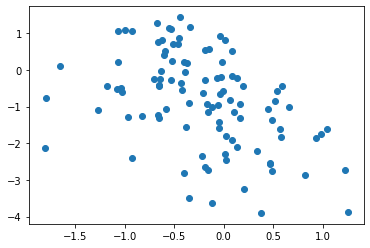

Model summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
Model plot


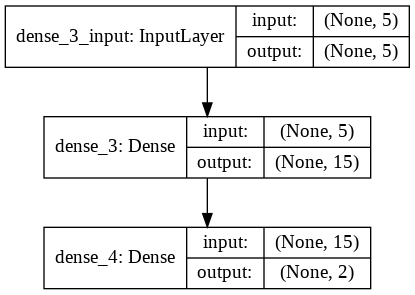

In [0]:
# The generator model takes as input a point from the latent space and generates a new sample, e.g. a vector with both the input and output elements of our function, e.g. x and x^2.
# We can define the size of the latent space for our problem and the shape or distribution of variables in the latent space.
# We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.

# Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
# Outputs: Two-element vector representing a generated sample for our function (x and x^2).

# It will have a single hidden layer with five nodes and will use the ReLU activation function and the He weight initialization. 
# The output layer will have two nodes for the two elements in a generated vector and will use a linear activation function.

#???
#A linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5 -x axes] for the first element and about [0.0, 0.25 -y xes] for the second element.

# The size of the latent dimension is parameterized in case we want to play with it later, and the output shape of the model is also parameterized, matching the function for defining the discriminator model.

# define the standalone generator model

def define_generator(latent_dim, n_outputs=2):
	generator_model = Sequential()
	generator_model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) #preco 15?
	generator_model.add(Dense(n_outputs, activation='linear'))
	return generator_model

#The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n) #randn(500) co to robi?
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator_model, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	print(x_input)
	# predict outputs
	X = generator_model.predict(x_input)
	print(X)
	# plot the results
	print('Predict generatoru z latent points, 5 dimenzii,100 hodnot')
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()
 
# size of the latent space
latent_dim = 5
# define the generator model
generator_model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(generator_model, latent_dim, 100)

# summarize the model
print('Model summary')
generator_model.summary()
# plot the model
print('Model plot')
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble the target function and its u-shape.

# Training the Generator Model

Gan model summary :
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 2)                 122       
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________
Gan model plot: 


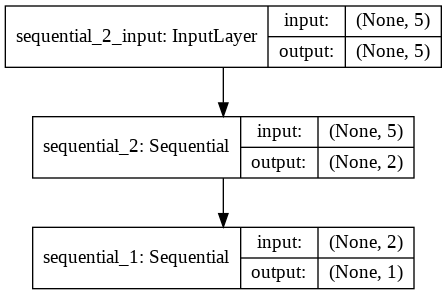

In [0]:
# The weights in the generator model are updated based on the performance of the discriminator model.
# When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

# The generator model is only concerned with the discriminator’s performance on fake examples. 
# Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

# When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. 
# Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

# We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this 
# as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.
# Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
# Outputs: Binary classification, likelihood the sample is real (or fake).


# define the combined generator and discriminator model, for updating the generator
def define_gan(generator_model, discriminator_model):
	# make weights in the discriminator not trainable
	discriminator_model.trainable = False
	# connect them
	gan_model = Sequential()
	# add generator
	gan_model.add(generator_model)
	# add the discriminator
	gan_model.add(discriminator_model)
	# compile model
	gan_model.compile(loss='binary_crossentropy', optimizer='adam')
	return gan_model

# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


# Training GAN

In [0]:
# train the composite gan model / diskriminator OFF
# The train_gan() function below demonstrates this, although it is pretty uninteresting as only the generator will be updated each epoch, leaving the discriminator with default model weights.

# def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
# 	# manually enumerate epochs
# 	for i in range(n_epochs):
# 		# prepare points in latent space as input for the generator
# 		x_gan = generate_latent_points(latent_dim, n_batch)
# 		# create inverted labels for the fake samples
# 		y_gan = ones((n_batch, 1))
# 		# update the generator via the discriminator's error
# 		gan_model.train_on_batch(x_gan, y_gan)
  
# Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.
# This requires combining elements from the train_discriminator() function defined in the discriminator section and the train_gan() function defined above. 
# It also requires that the generate_fake_samples() function use the generator model to generate fake samples instead of generating random numbers.

def train(generator_model, discriminator_model, gan_model, latent_dim, n_epochs=10000, n_batch=128,n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
		# update discriminator
		discriminator_model.train_on_batch(x_real, y_real)
		discriminator_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
  # evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
		  summarize_performance(i, generator_model, discriminator_model, latent_dim)

# FINAL CODE X2

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 0.82 0.31


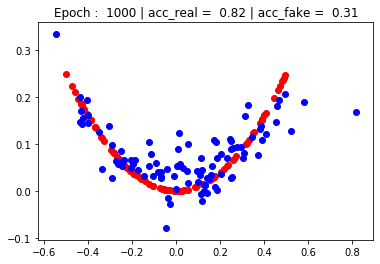

2000 0.44 0.7


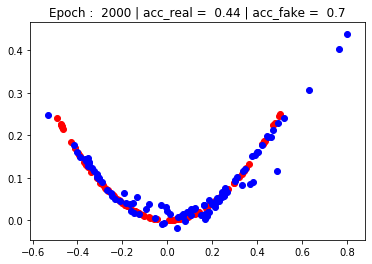

3000 0.48 0.42


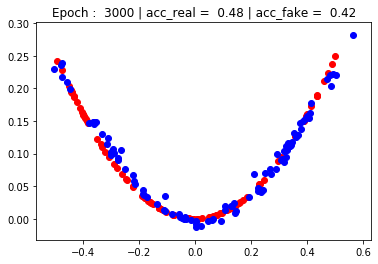

4000 0.66 0.46


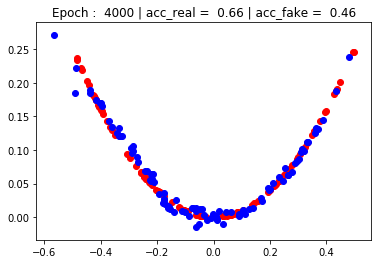

5000 0.67 0.42


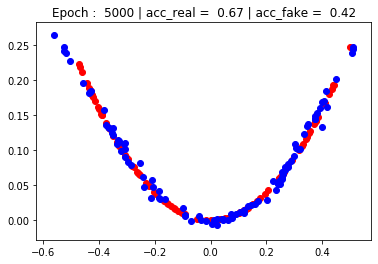

6000 0.73 0.56


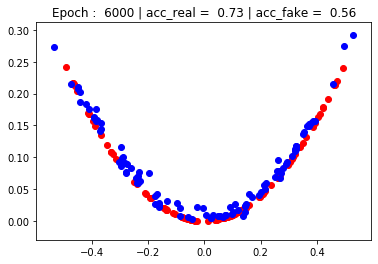

7000 0.64 0.5


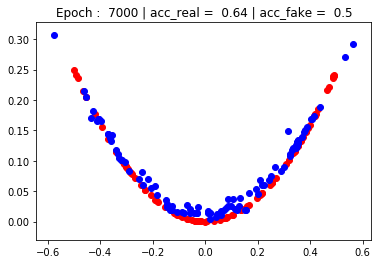

8000 0.55 0.57


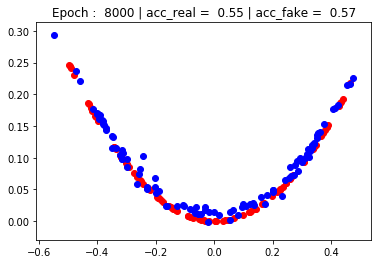

9000 0.73 0.48


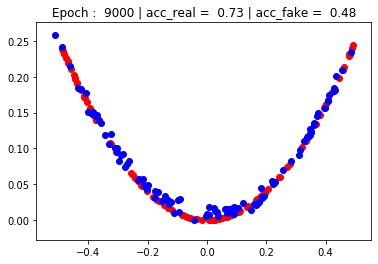

10000 0.65 0.44


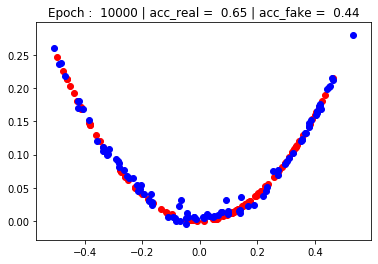

11000 0.68 0.5


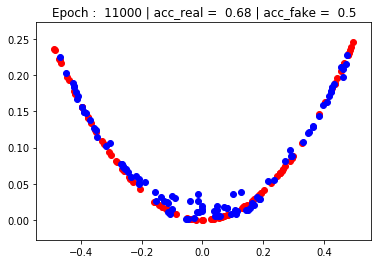

12000 0.71 0.6


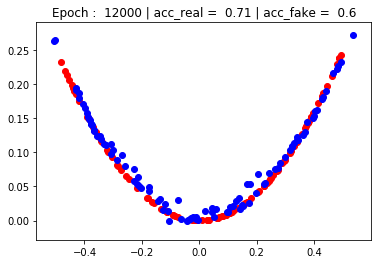

13000 0.56 0.67


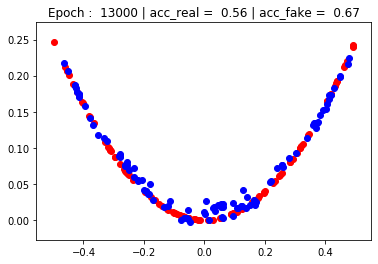

14000 0.49 0.68


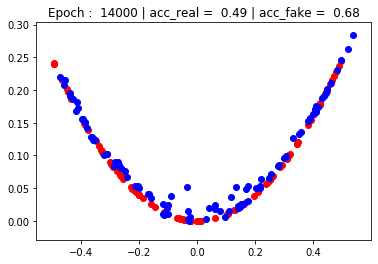

15000 0.5 0.63


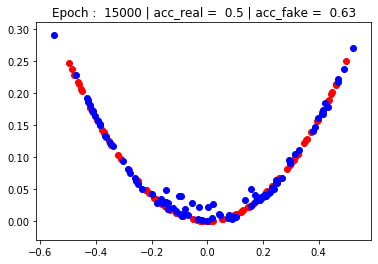

16000 0.67 0.49


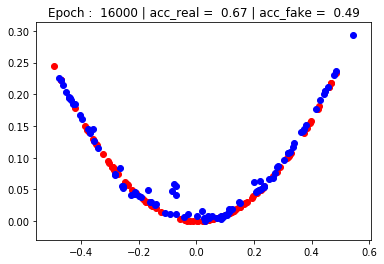

17000 0.75 0.45


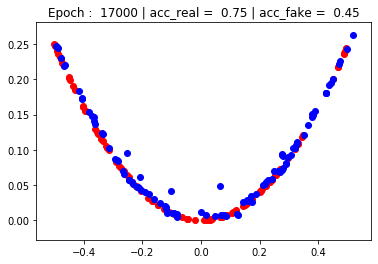

18000 0.66 0.4


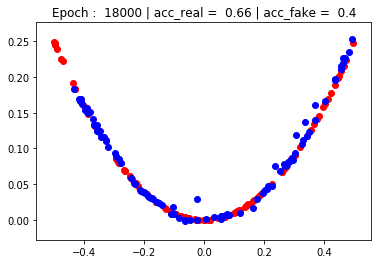

19000 0.64 0.45


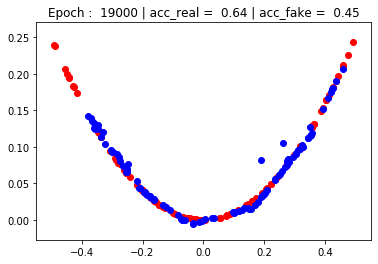

20000 0.55 0.42


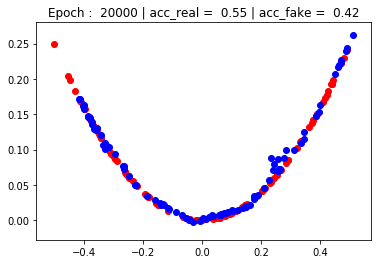

21000 0.42 0.63


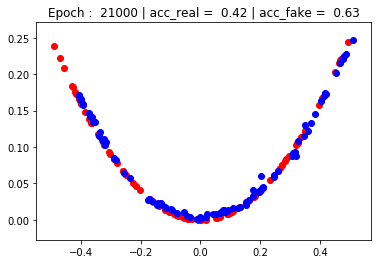

22000 0.42 0.71


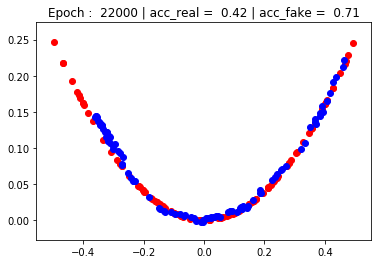

23000 0.65 0.49


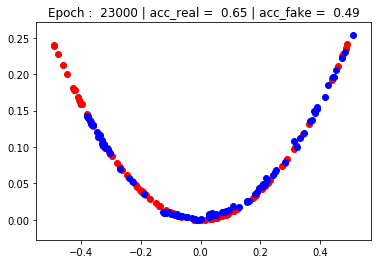

24000 0.54 0.5


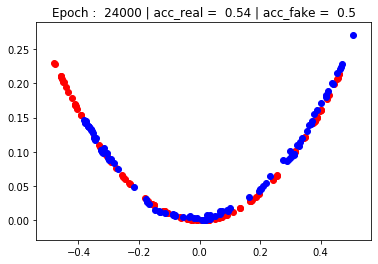

25000 0.57 0.6


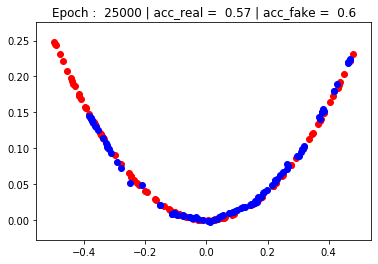

26000 0.74 0.31


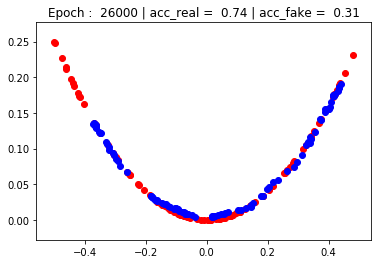

27000 0.42 0.74


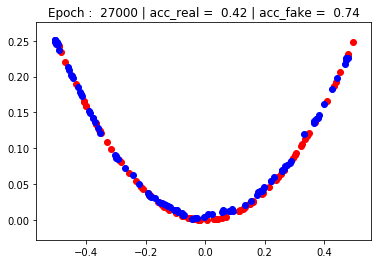

28000 0.57 0.5


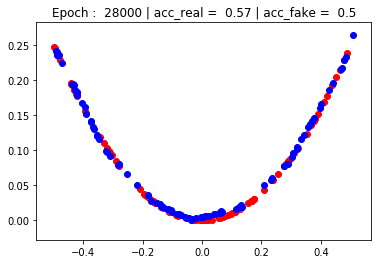

29000 0.58 0.58


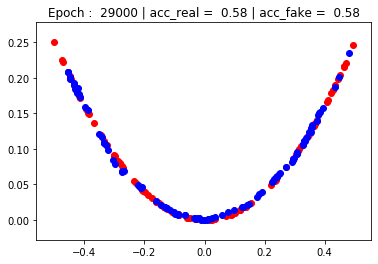

30000 0.63 0.53


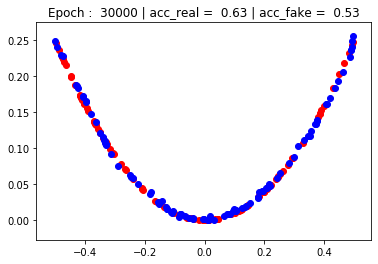

31000 0.46 0.56


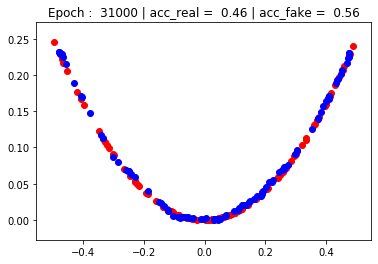

32000 0.51 0.69


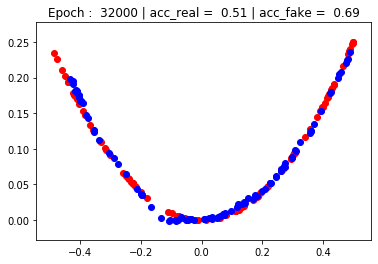

33000 0.4 0.71


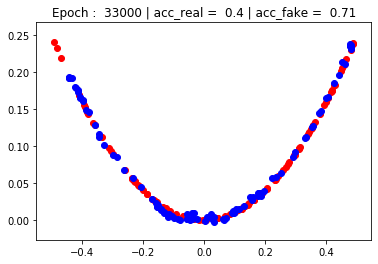

34000 0.36 0.56


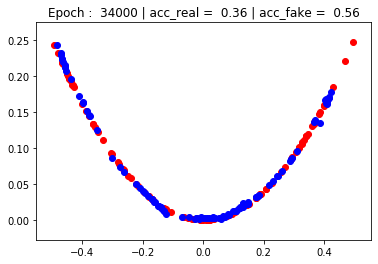

35000 0.66 0.32


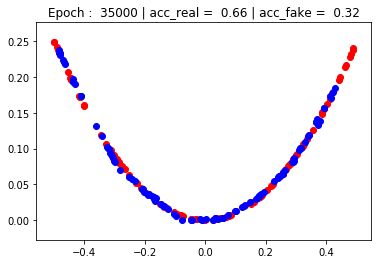

36000 0.51 0.49


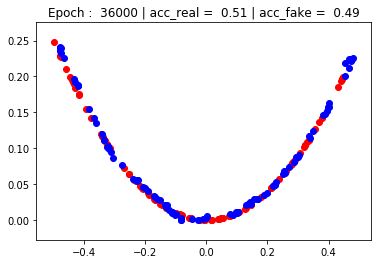

37000 0.56 0.56


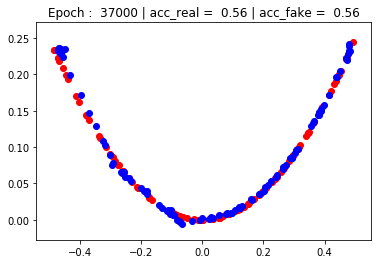

38000 0.61 0.4


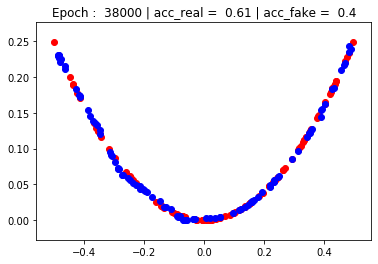

39000 0.34 0.58


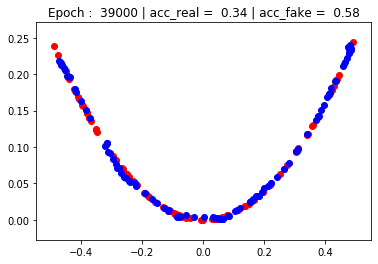

40000 0.57 0.54


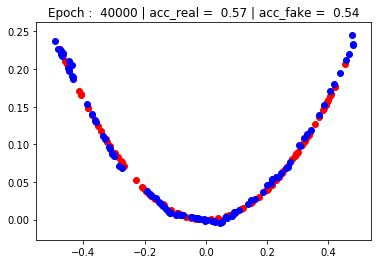

41000 0.62 0.59


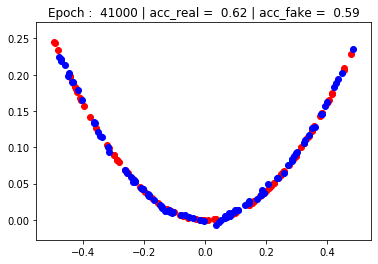

42000 0.59 0.55


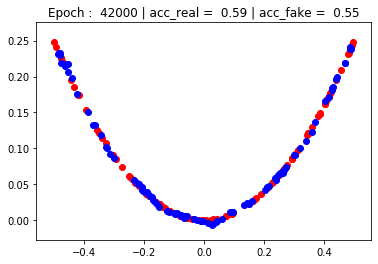

43000 0.46 0.63


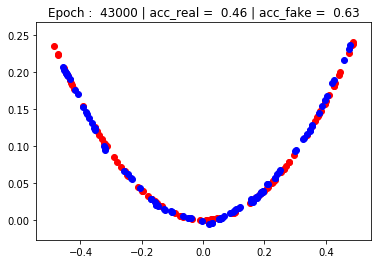

44000 0.49 0.58


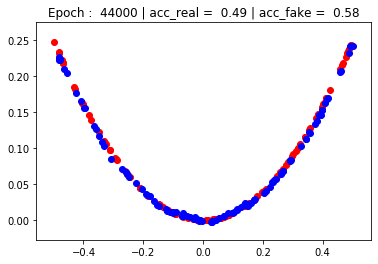

45000 0.44 0.58


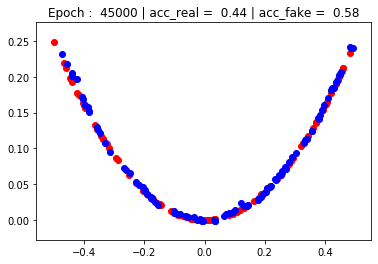

46000 0.62 0.44


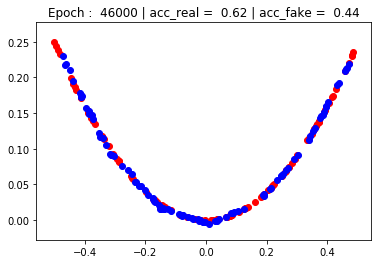

47000 0.54 0.52


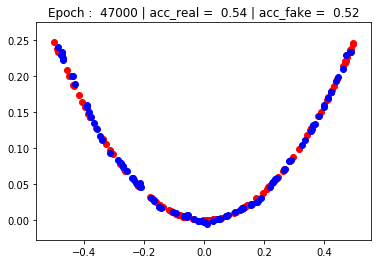

48000 0.5 0.41


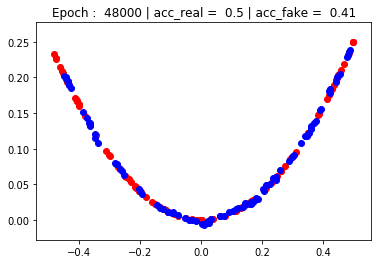

49000 0.44 0.58


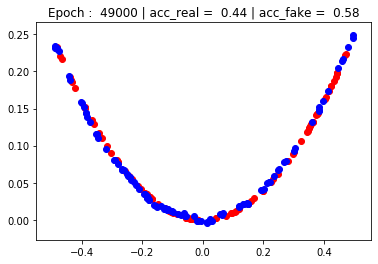

50000 0.52 0.52


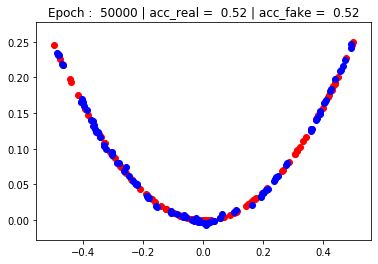

51000 0.43 0.61


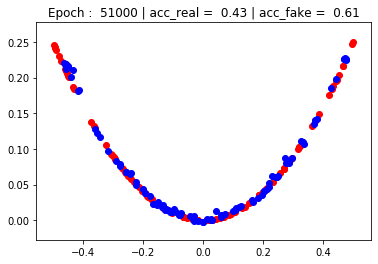

52000 0.6 0.68


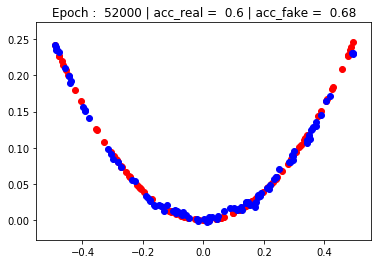

53000 0.52 0.33


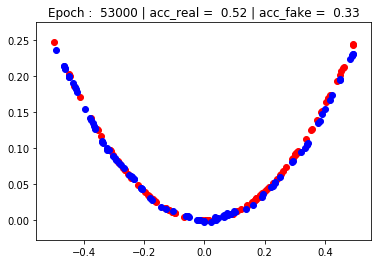

54000 0.56 0.71


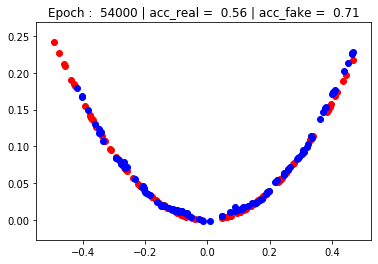

55000 0.54 0.48


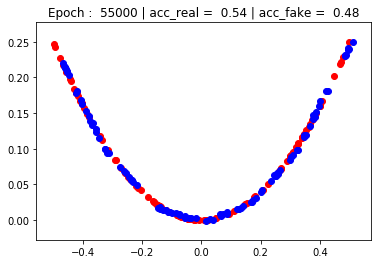

56000 0.52 0.53


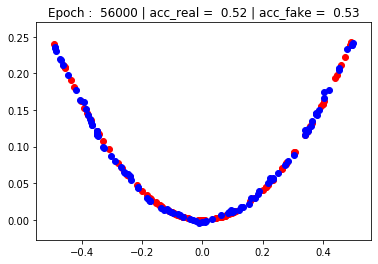

57000 0.53 0.6


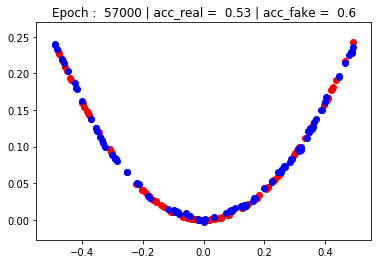

58000 0.47 0.47


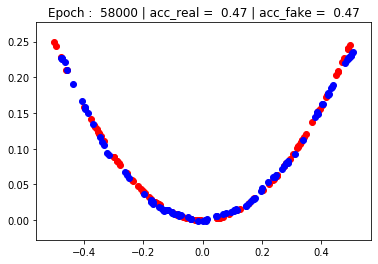

59000 0.6 0.52


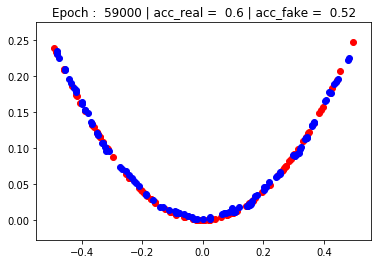

60000 0.58 0.53


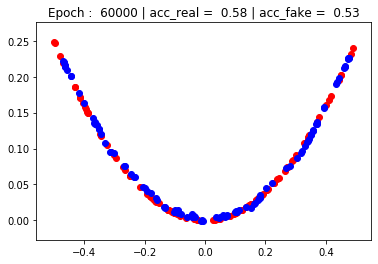

61000 0.45 0.68


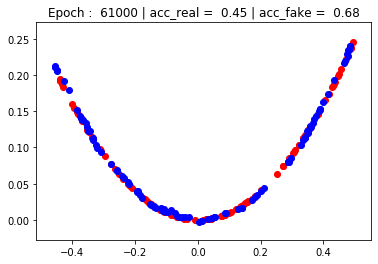

62000 0.54 0.45


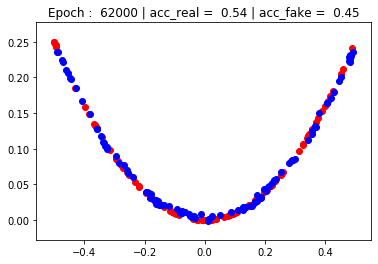

63000 0.61 0.41


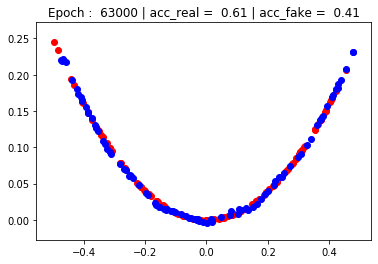

64000 0.45 0.7


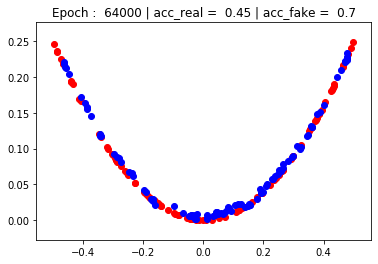

65000 0.64 0.46


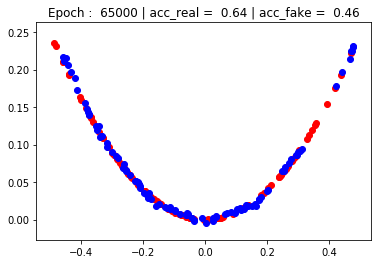

66000 0.63 0.28


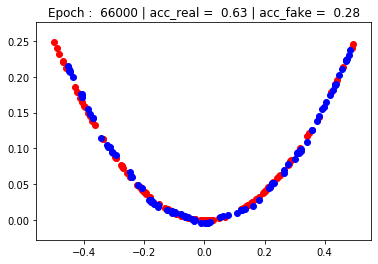

67000 0.54 0.58


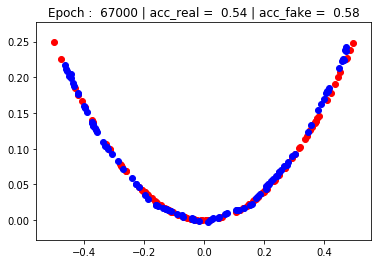

68000 0.64 0.56


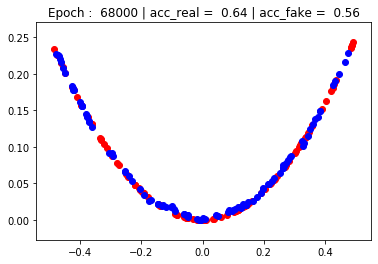

69000 0.72 0.44


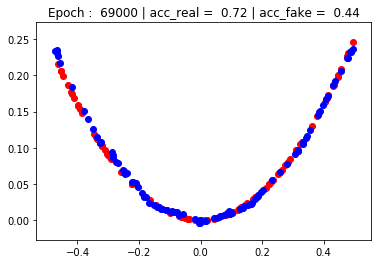

70000 0.59 0.51


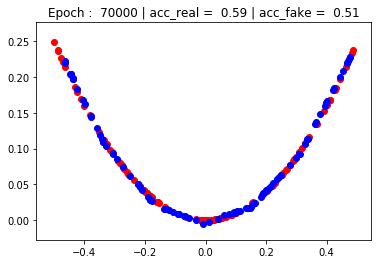

71000 0.51 0.45


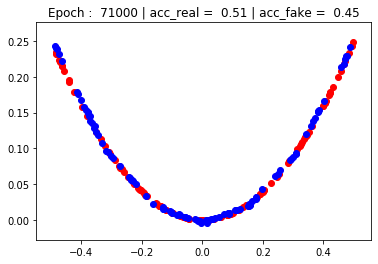

72000 0.6 0.78


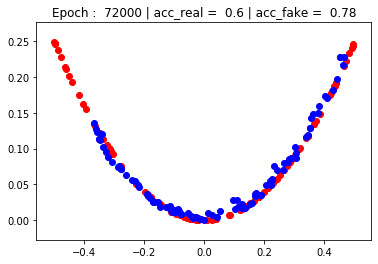

73000 0.74 0.58


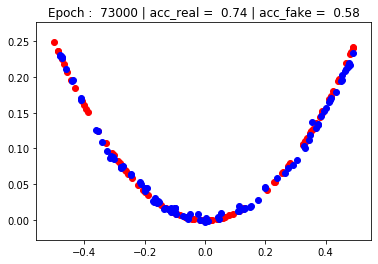

74000 0.48 0.51


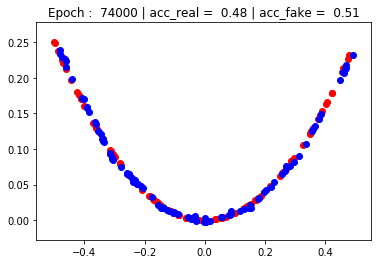

75000 0.58 0.56


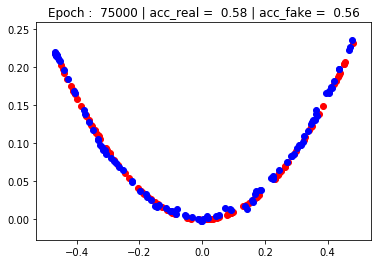

76000 0.43 0.62


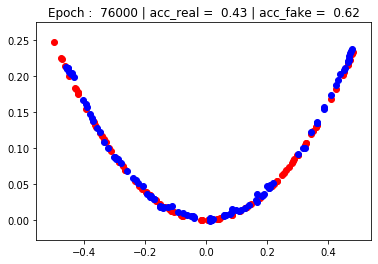

77000 0.45 0.47


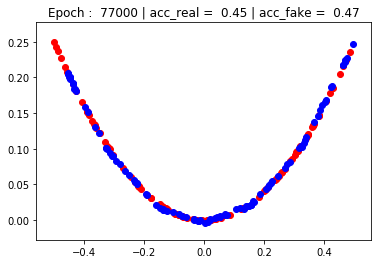

78000 0.72 0.39


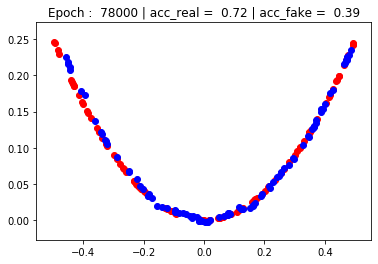

79000 0.59 0.63


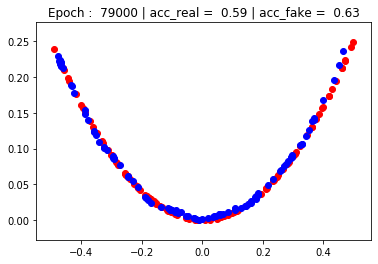

80000 0.49 0.46


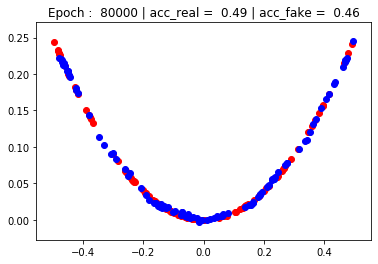

81000 0.63 0.54


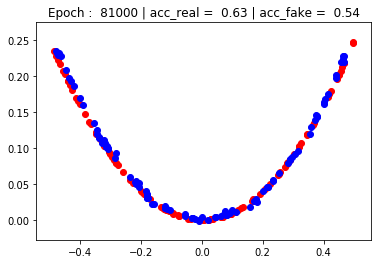

82000 0.68 0.42


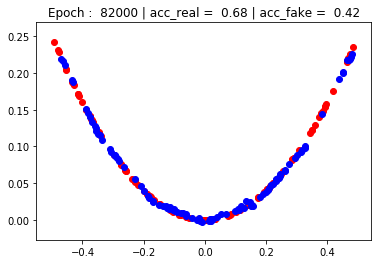

83000 0.66 0.39


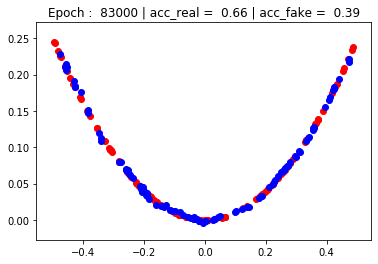

84000 0.64 0.45


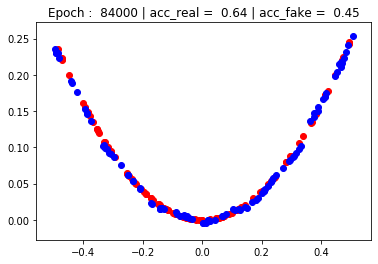

85000 0.68 0.46


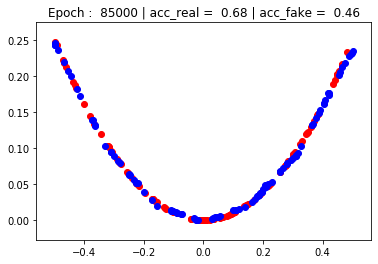

86000 0.66 0.4


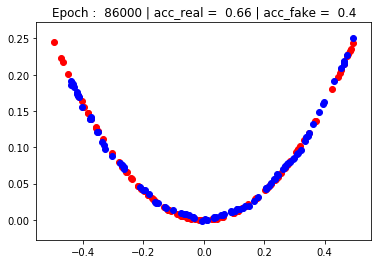

87000 0.6 0.54


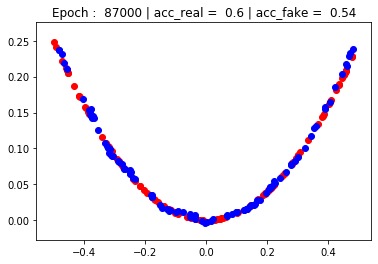

88000 0.65 0.42


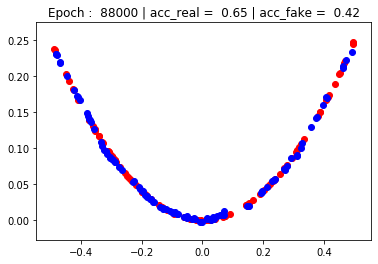

89000 0.6 0.34


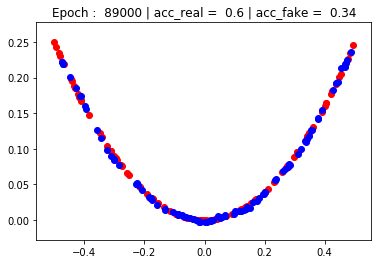

90000 0.58 0.7


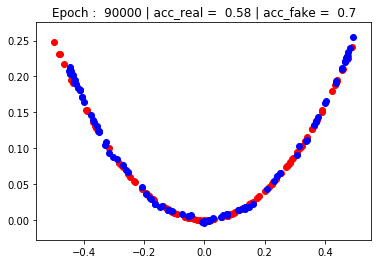

91000 0.59 0.65


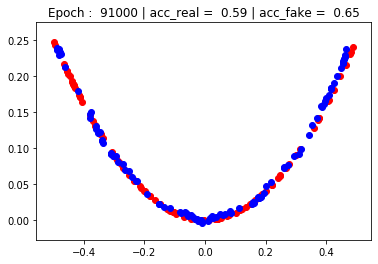

92000 0.63 0.39


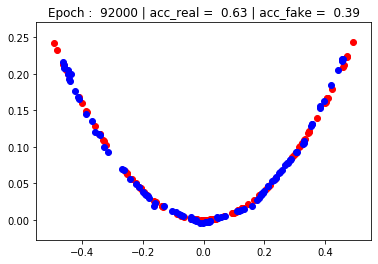

93000 0.62 0.64


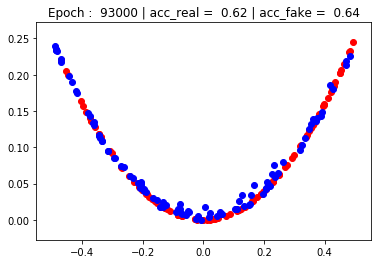

94000 0.41 0.58


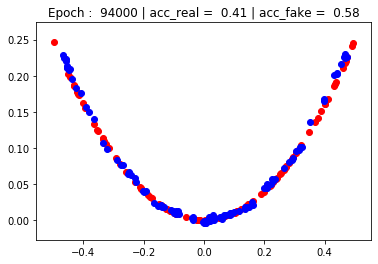

95000 0.61 0.41


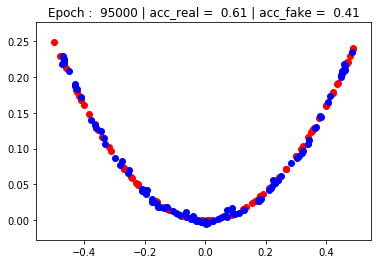

96000 0.59 0.5


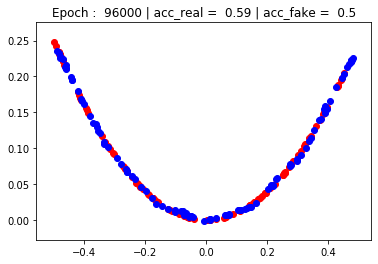

97000 0.69 0.4


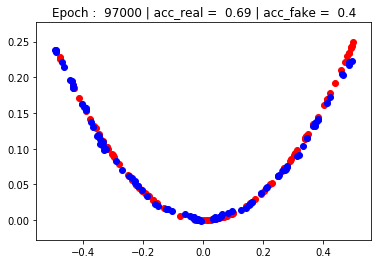

98000 0.65 0.54


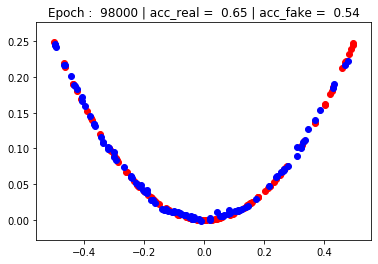

99000 0.58 0.52


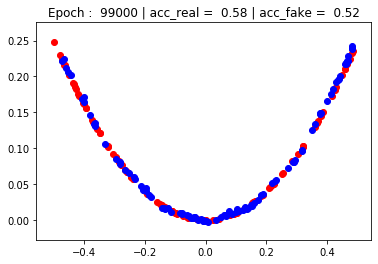

100000 0.5 0.41


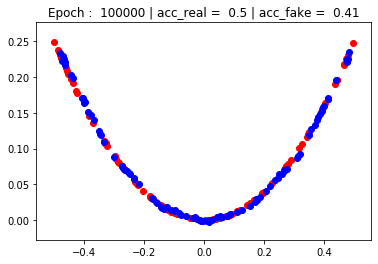

744.5579187990006


In [0]:
# DENSE VRSTVA 
# Just your regular densely-connected NN layer. (https://keras.io/layers/core/)
# Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# define the standalone DISCRIMINATOR model

# vstup 2 vektory 1D hodnot
# vystup 25 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 25 (vystup z predchadzajucej)
# 1 neuron vystupna vrstva 
# AKTIVACNA FUNKCIA : sigmoid (0-1)

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam
# METRICS : accuracy

start = timer()

def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# vstup su hodnoty (5) z latent space - 5 dimenzii = 5hodnot, dimenziu viem nastavit (five-element vector of Gaussian random numbers)
# 15 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 15 (vystup z predchadzajucej)
# vystup 2 hodnoty x a y(x na druhu),
# AKTIVACNA FUNKCIA : linear
# Linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5 -x axes] for the first element and about [0.0, 0.25 -y xes] for the second element.

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.title('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
	pyplot.show()
 
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# batch size - staci do 512
# epochy - kolko treba
# n_eval - po kolkych epochach vyhodnocovat

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=100000, n_batch=512, n_eval=1000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i+1, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

end = timer()
print(end - start)



# Plot title,xlabel,ylabel

5000


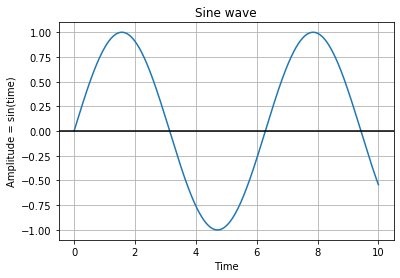

In [0]:
# Get x values of the sine wave

time= np.arange(0, 10, 1/500);
print(len(time))

# Amplitude of the sine wave is sine of a variable like time
amplitude = np.sin(time) 
# Plot a sine wave using time and amplitude obtained for the sine wave

pyplot.plot(time, amplitude)
# Give a title for the sine wave plot
pyplot.title('Sine wave')
# Give x axis label for the sine wave plot
pyplot.xlabel('Time')
# Give y axis label for the sine wave plot
pyplot.ylabel('Amplitude = sin(time)')
pyplot.grid(True, which='both')
pyplot.axhline(y=0, color='k')
pyplot.show()

# Display the sine wave
pyplot.show()

In [0]:
#I tried with more hidden layer for the discriminator and with the LeakyReLu activation (see below)
#It seems the tthe reuslts are a littel bit mor stable

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# FINAL CODE SINUS






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




5000 0.33 0.83


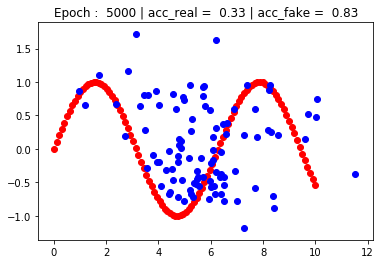

10000 0.45 0.83


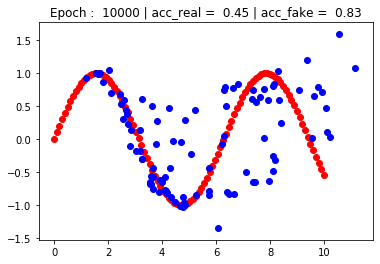

15000 0.28 0.84


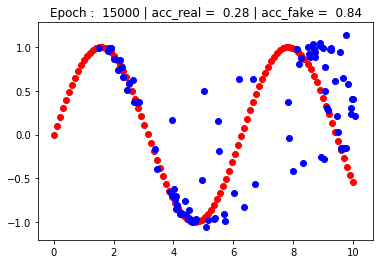

20000 0.35 0.86


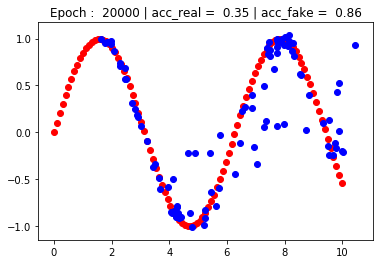

25000 0.31 0.79


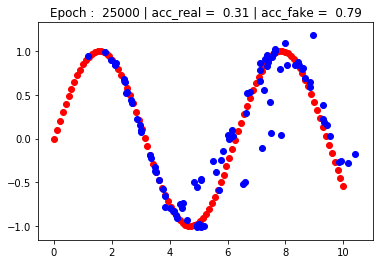

30000 0.36 0.9


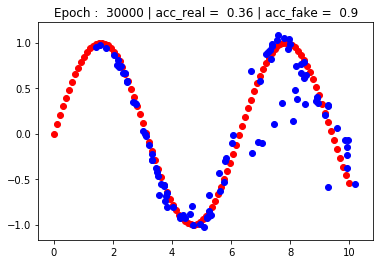

35000 0.57 0.73


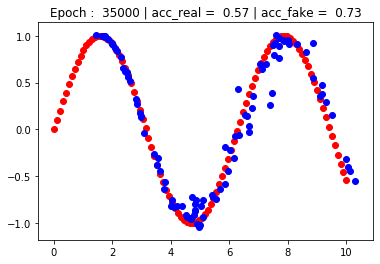

40000 0.31 0.87


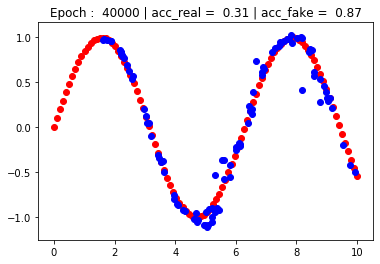

45000 0.37 0.84


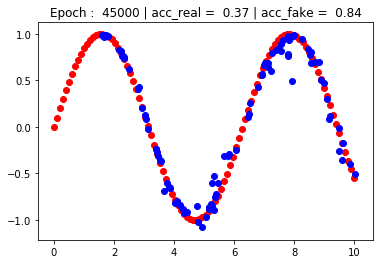

50000 0.32 0.85


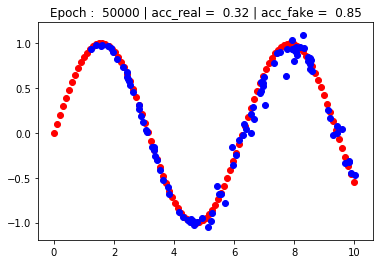

55000 0.32 0.89


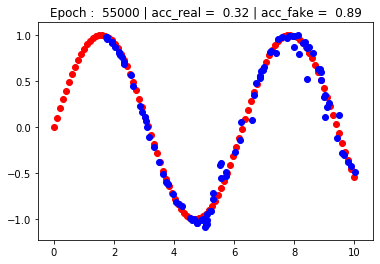

60000 0.51 0.81


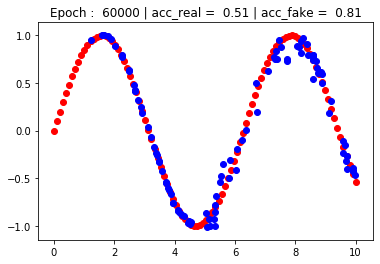

65000 0.34 0.8


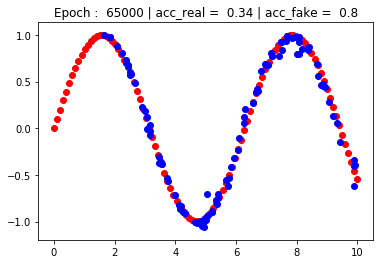

70000 0.53 0.78


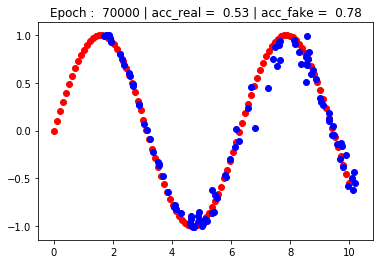

75000 0.39 0.83


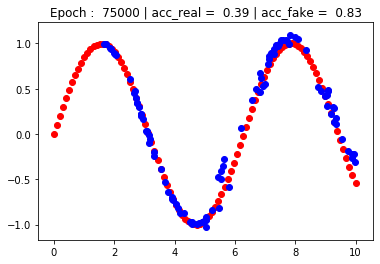

80000 0.35 0.85


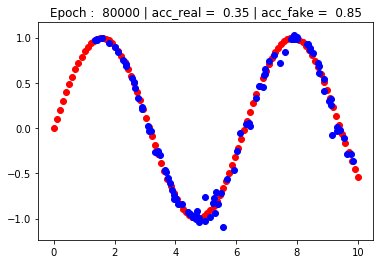

85000 0.38 0.92


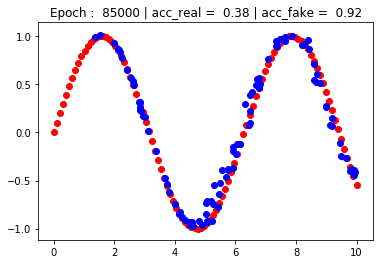

90000 0.39 0.9


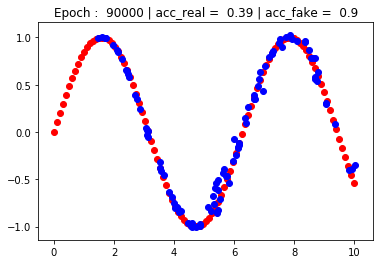

95000 0.45 0.83


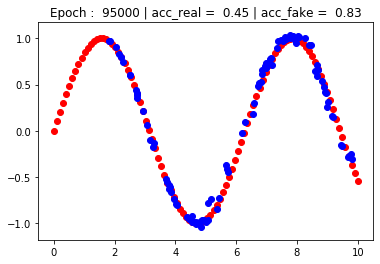

100000 0.51 0.76


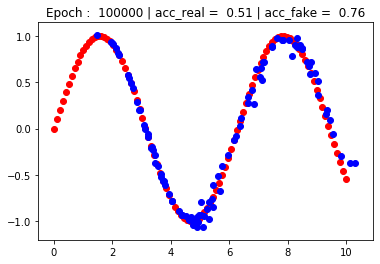

105000 0.38 0.78


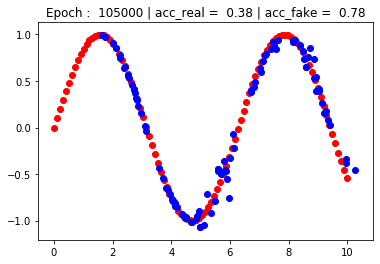

110000 0.5 0.85


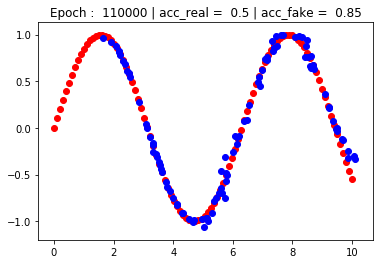

115000 0.61 0.78


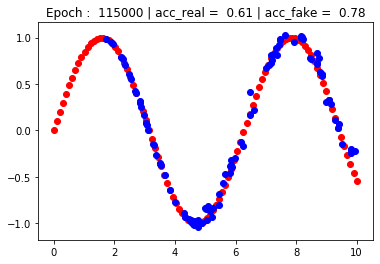

120000 0.57 0.82


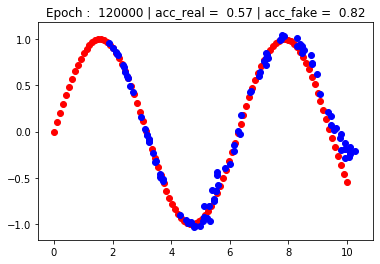

125000 0.62 0.91


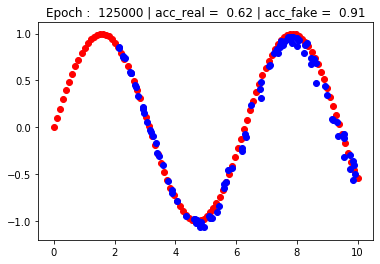

130000 0.57 0.71


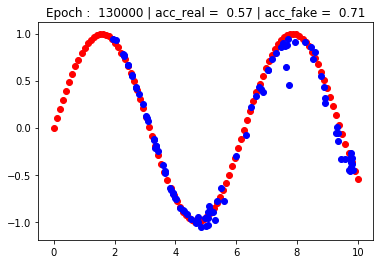

135000 0.65 0.82


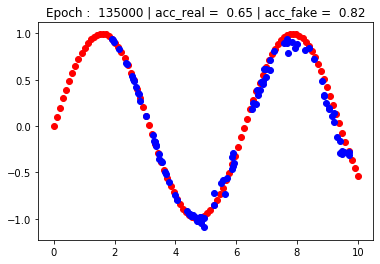

140000 0.58 0.77


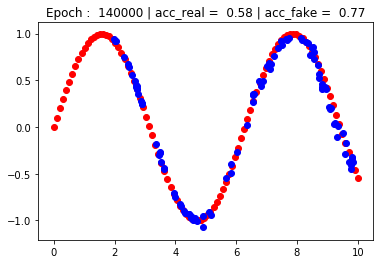

145000 0.54 0.79


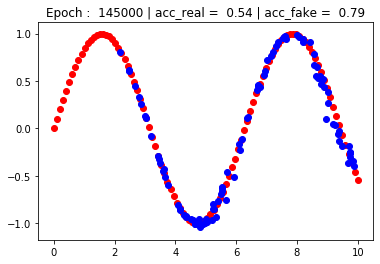

150000 0.61 0.58


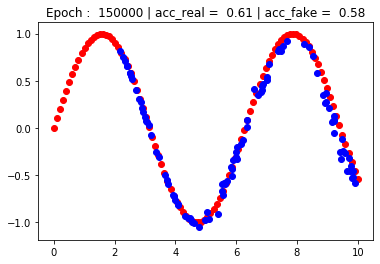

155000 0.73 0.68


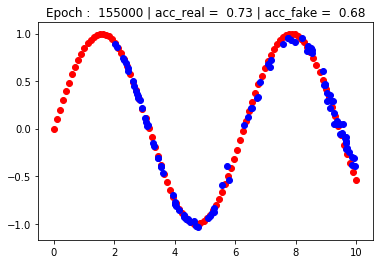

160000 0.66 0.78


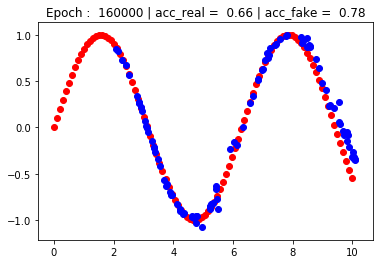

165000 0.75 0.68


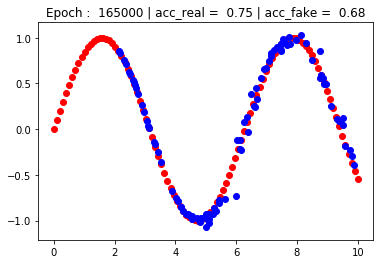

170000 0.6 0.76


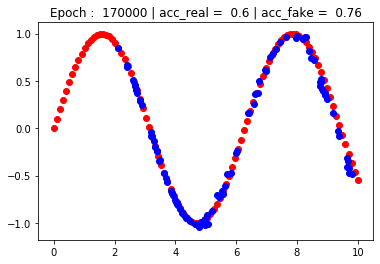

175000 0.68 0.85


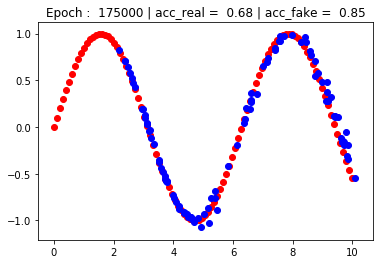

180000 0.39 0.88


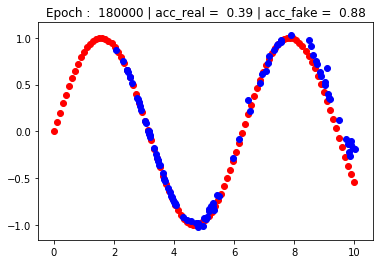

185000 0.74 0.81


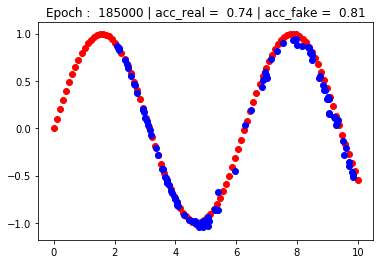

190000 0.66 0.71


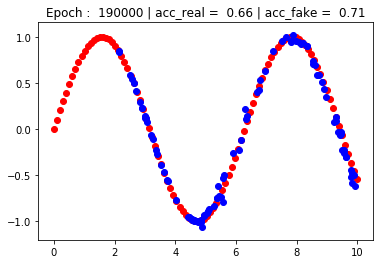

195000 0.55 0.85


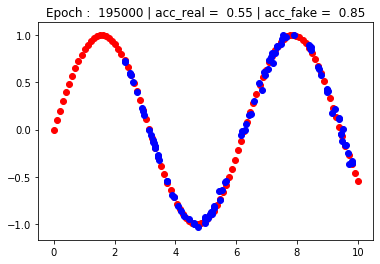

200000 0.56 0.85


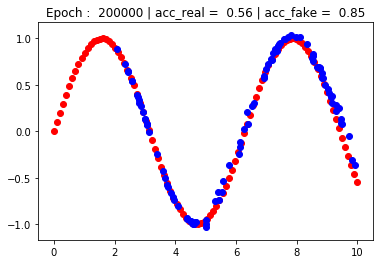

205000 0.66 0.76


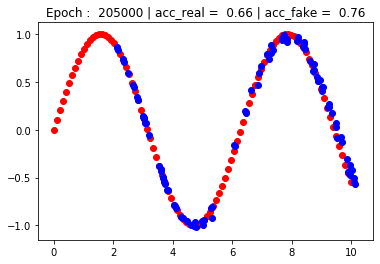

210000 0.49 0.82


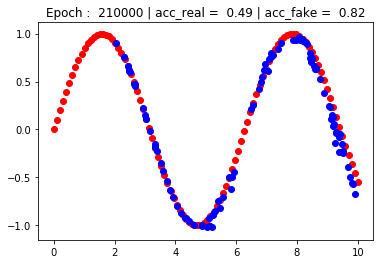

215000 0.56 0.88


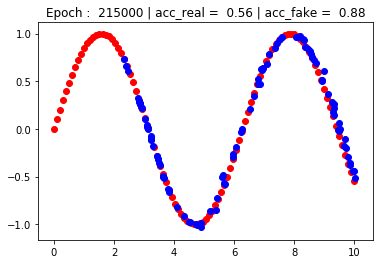

220000 0.81 0.82


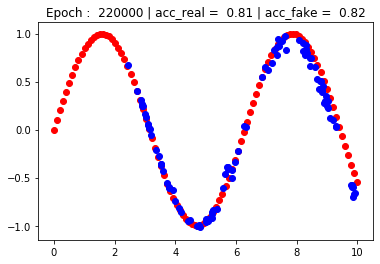

225000 0.78 0.76


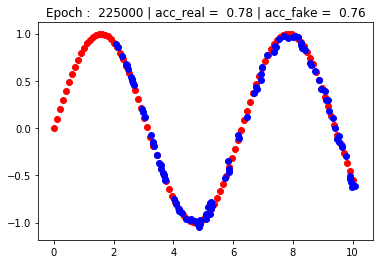

230000 0.83 0.81


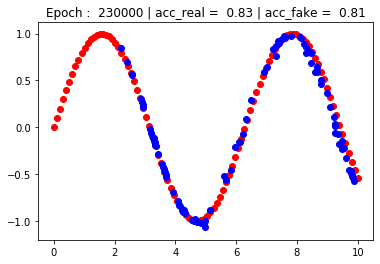

235000 0.65 0.65


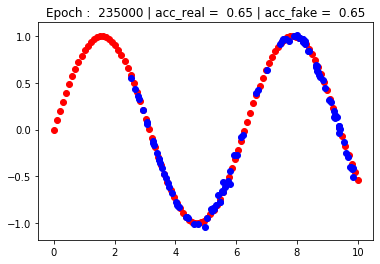

240000 0.71 0.79


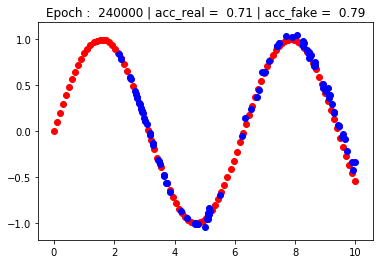

245000 0.75 0.65


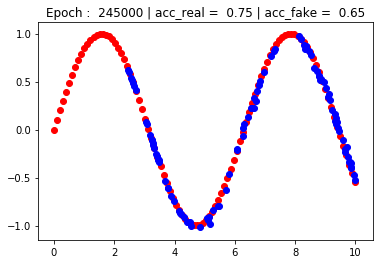

250000 0.59 0.86


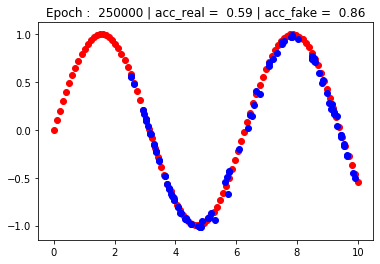

255000 0.54 0.89


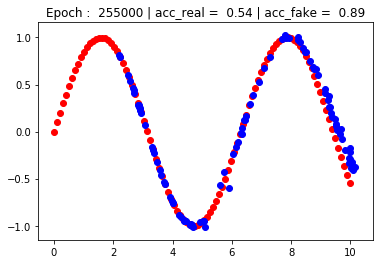

260000 0.5 0.72


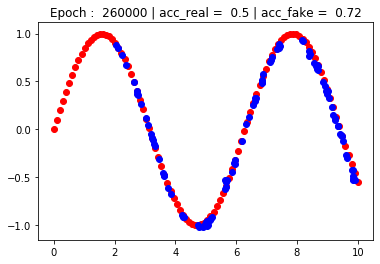

265000 0.8 0.58


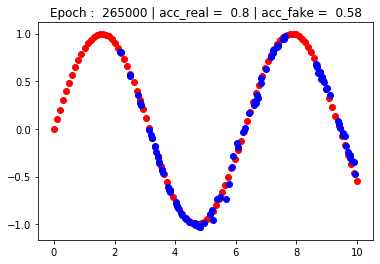

270000 0.56 0.94


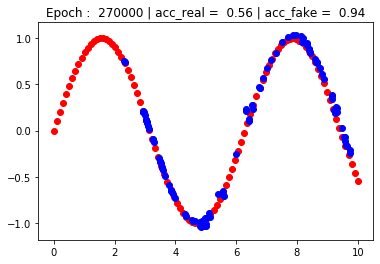

275000 0.62 0.75


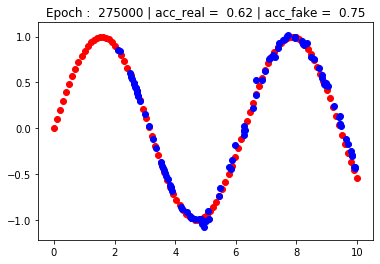

280000 0.58 0.63


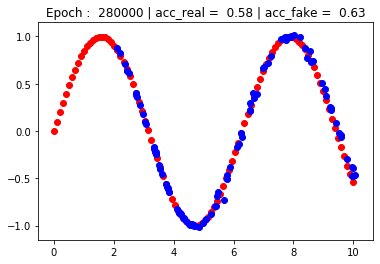

285000 0.64 0.86


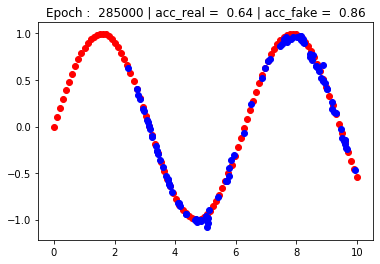

290000 0.55 0.72


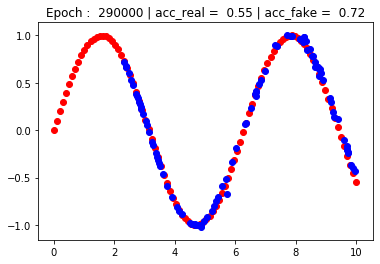

295000 0.48 0.85


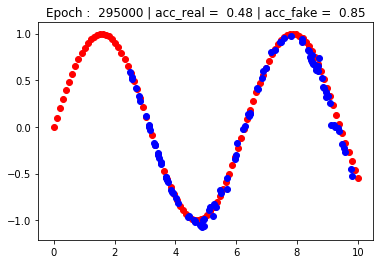

300000 0.68 0.84


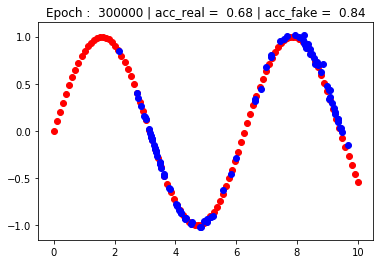

305000 0.62 0.87


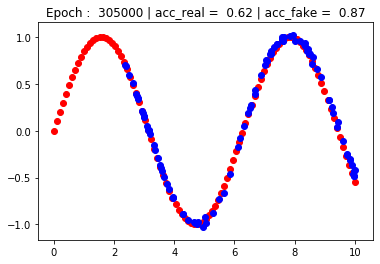

310000 0.63 0.77


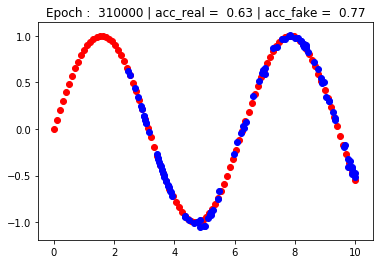

315000 0.65 0.61


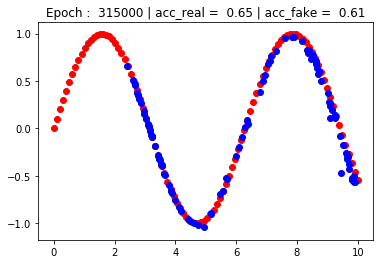

320000 0.83 0.85


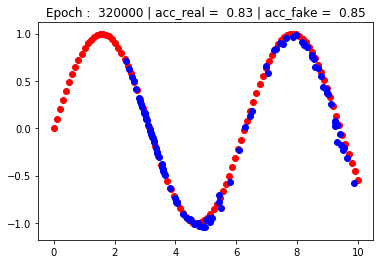

325000 0.75 0.75


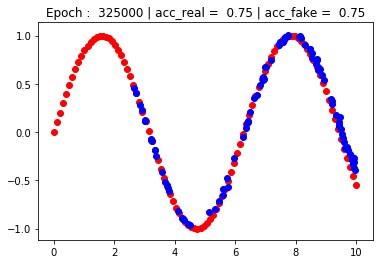

330000 0.58 0.86


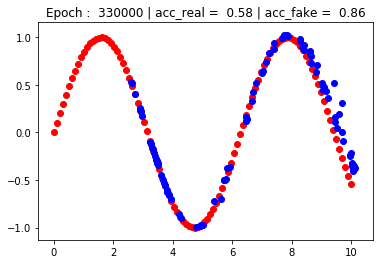

335000 0.62 0.88


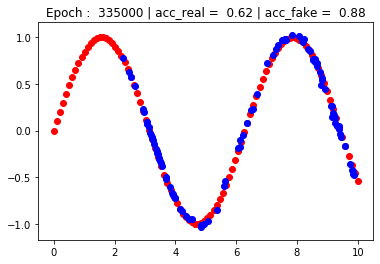

340000 0.71 0.6


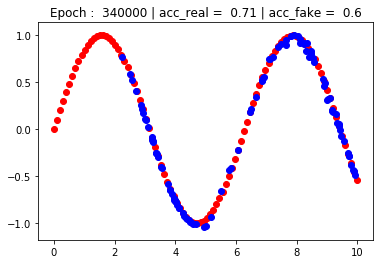

345000 0.75 0.75


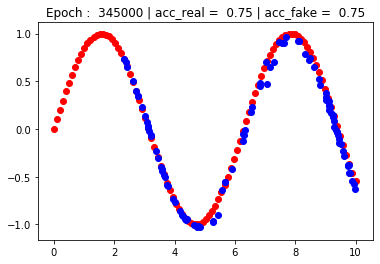

350000 0.66 0.63


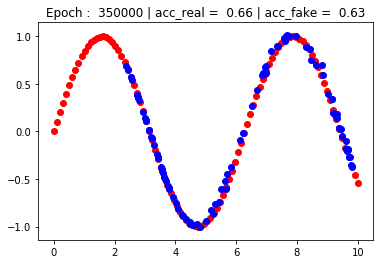

355000 0.88 0.59


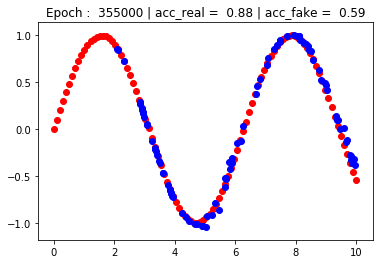

360000 0.74 0.66


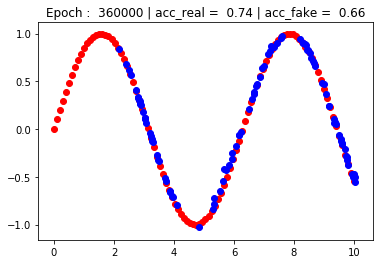

365000 0.79 0.57


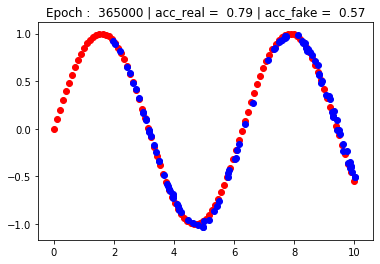

370000 0.64 0.7


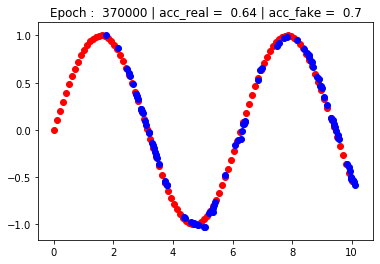

375000 0.79 0.87


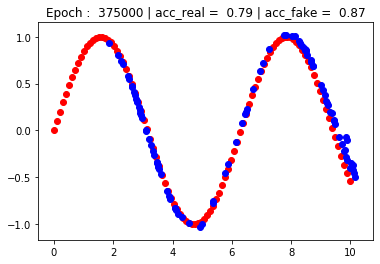

380000 0.8 0.64


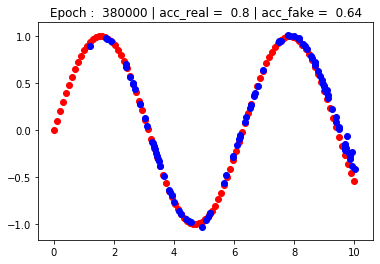

385000 0.94 0.47


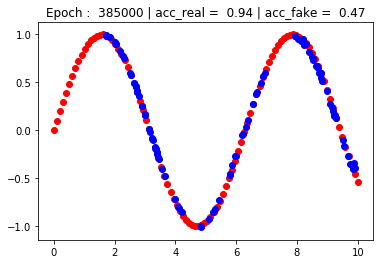

390000 0.51 0.59


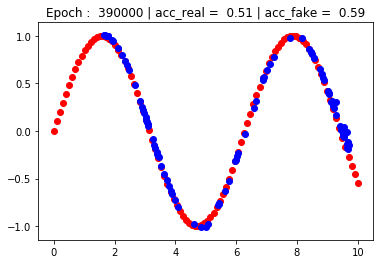

395000 0.58 0.88


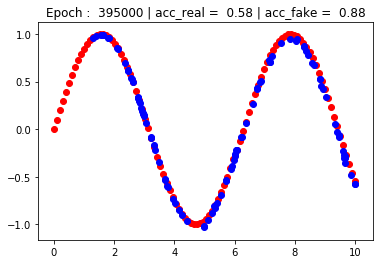

400000 0.64 0.9


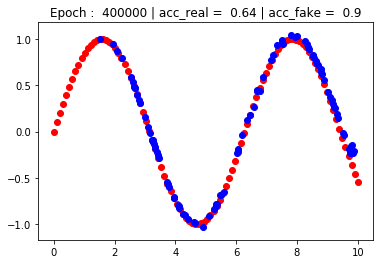

405000 0.59 0.64


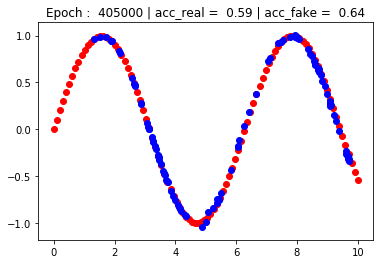

410000 0.87 0.15


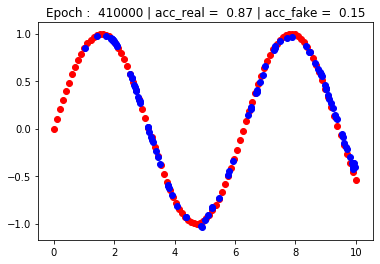

415000 0.6 0.63


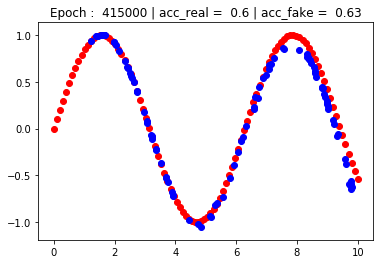

420000 0.52 0.79


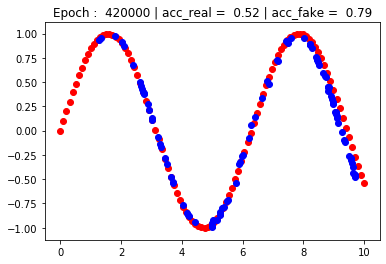

425000 0.82 0.8


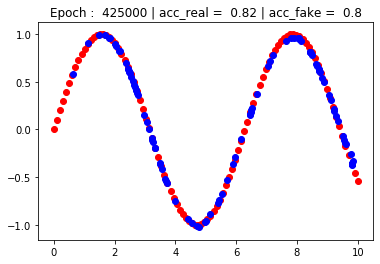

430000 0.44 0.73


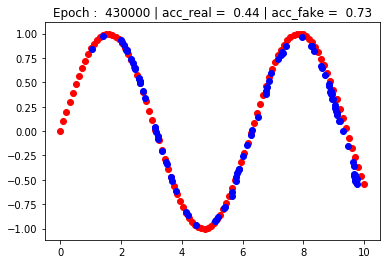

435000 0.88 0.75


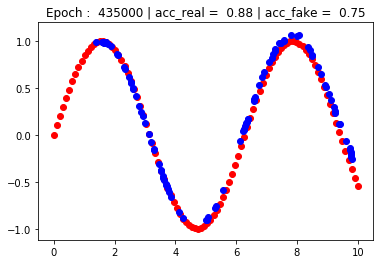

440000 0.45 0.92


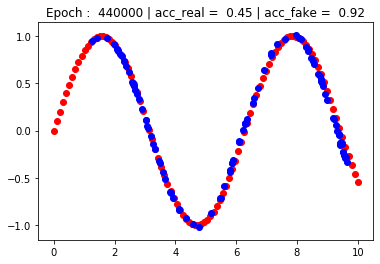

445000 0.58 0.83


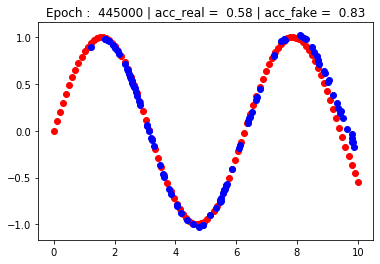

450000 0.79 0.58


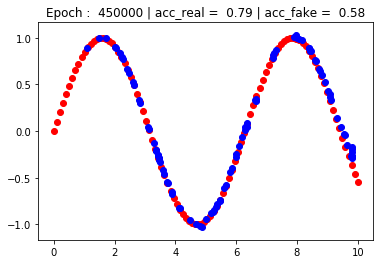

455000 0.54 0.93


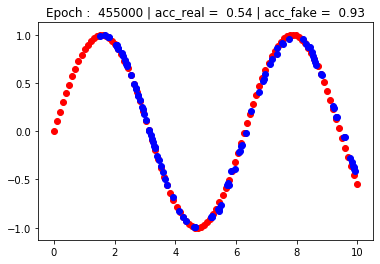

460000 0.46 0.8


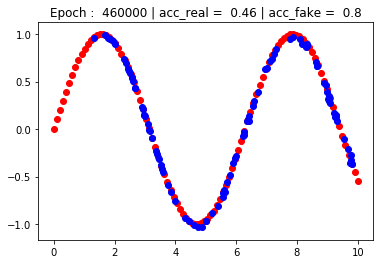

465000 0.83 0.57


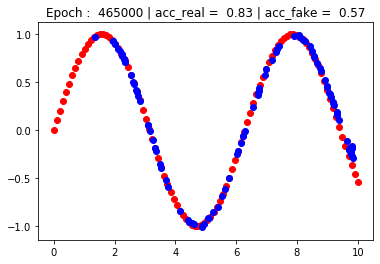

470000 0.49 0.48


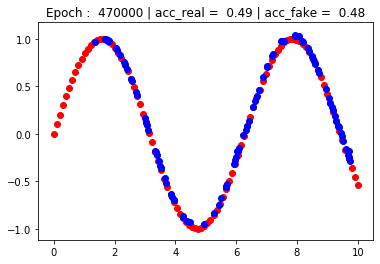

475000 0.61 0.78


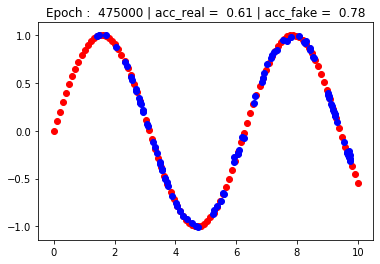

480000 0.61 0.52


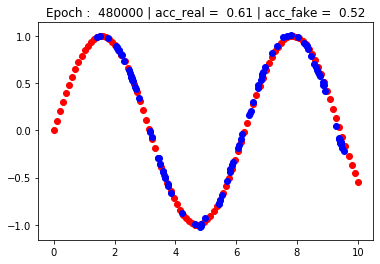

485000 0.8 0.48


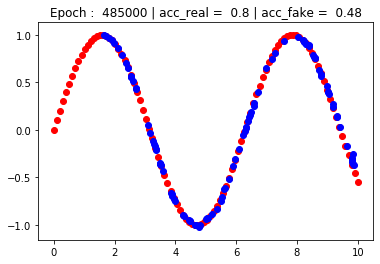

490000 0.48 0.33


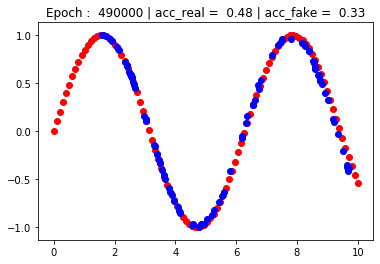

495000 0.48 0.79


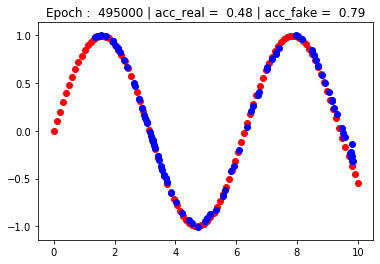

500000 0.48 0.47


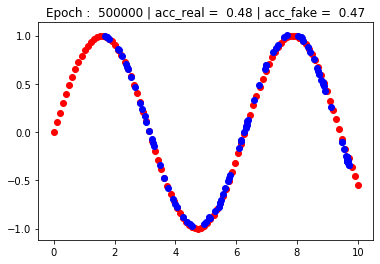

3616.1400634009997


In [0]:
# train a generative adversarial network on a one-dimensional function
# define the standalone discriminator model
# model.add(LeakyReLU(alpha=0.3))

start = timer()

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5,  kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  #model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [0,5000]
  X1 = np.linspace(0,10,n)
  # generate outputs 
  X2 = np.sin(X1) 
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples 
	x_real, y_real = generate_real_samples(n)
 # evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
 	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
 	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
 	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.title('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
	pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=500000, n_batch=512, n_eval=5000): #batchsize kludne zvacsit
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i+1, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)


end = timer()
print(end - start) # Time in seconds, e.g. 5.38091952400282

# nastavit zastavenie ked bude acc 50/50 alebo nejak to proste optimalizovat?

5000
5000


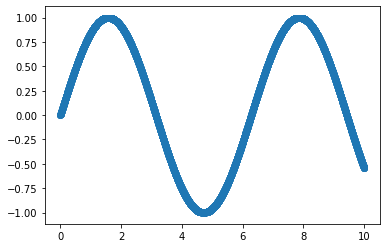

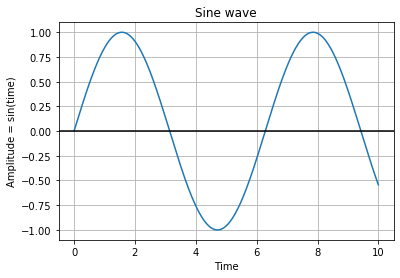

In [0]:
X1 = np.linspace(0,10,5000) 
X2 = np.sin(X1) 

#X1 = np.sort(np.round(rand(1000)*5000))
print(len(X1))
#X2 = np.sin(2*np.pi*f*X1) 
print(len(X2))
pyplot.scatter(X1,X2)
pyplot.show()

pyplot.plot(X1,X2)
# Give a title for the sine wave plot
pyplot.title('Sine wave')
# Give x axis label for the sine wave plot
pyplot.xlabel('Time')
# Give y axis label for the sine wave plot
pyplot.ylabel('Amplitude = sin(time)')
pyplot.grid(True, which='both')
pyplot.axhline(y=0, color='k')
pyplot.show()

# Display the sine wave
pyplot.show()

In [0]:


# simple function
def calculate(x):
	return np.sin(x)

# demonstrate simple x^2 function
from matplotlib import pyplot
 
# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
print('vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)')
pyplot.plot(inputs, outputs)
pyplot.show()

# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
 
# # generate randoms sample from x^2 - FUNKCIA

def generate_samples(n=100):
	X1 = rand(n) - 0.5
	#print('Nahodne hodnoty v rozmedzi -0.5 az 0.5')
	#print(X1)
 
	# generate outputs X^2 (quadratic) - vypocet vystupu
	X2 = X1 * X1
	# stack arrays - spojim dva stlpce X1 a X2
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))  #vystup je v returne, dalej ukladam do x2_data 

# generate n REAL samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1)) # tymto hovorim ze vsetky vygenerovane data su real, same jednotky
	return X, y

# generate n FAKE samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	#print('Nahodne hodnoty v rozmedzi -1 az 1')
	#print(X1)
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1)) # tymto hovorim ze vsetky vygenerovane data su fake, same nuly
	return X, y 
 	
# generate samples
x2_data = generate_samples() 
# plot samples
print('Vystup z nahodnych od -0,5 do 0,5 (100 vzoriek):')
pyplot.scatter(x2_data[:, 0], x2_data[:, 1])
pyplot.show()

# generate fake samples
print('Vystup z nahodnych od -1 do 1 (100 vzoriek):')
x2_data = generate_fake_samples(100) 
# plot samples
pyplot.scatter(X[:,0], X[:,1])
pyplot.show()

In [0]:

n=100
X1 = np.linspace(0,10,n)
X1

-38.152970592451304

# Metrics eval